# Validación de la rutina que calcula el VAD

La idea es calcular el Vr a partir de un sondeo y luego calcular nuevamente u,v con VAD para realizar una comparación, similar a Gao 2004. 
Voy a usar un sondeo de Santa Rosa y por lo tanto voy a interpolar a la grilla del radar de Anguil para 120km y así (posiblemten) comparar cualitativamente las imagenes. 
### Pruebas:
* Interpolación directa, cubriendo con datos toda la grilla del radar.
* Incorporando errores aleatorios, con y sin filtro
* Interpolando y luego quitando datos para que quede una grilla de datos rala (o sea lo que pasa normalmente y tal vez con errores incluidos.

$ Vr =  v \cos(\theta) \cos(\phi) + u \cos(\theta) \sin(\phi) - w \sin(\theta)$

Donde 

$ \theta $=  ángulo de elevación 

$ \phi $= azimut

### Cálculo de errores:

Voy a calcular la raiz del error cuadrático medio (rms), el error relativo al rms y la correlación.

$ rms = \sqrt{ \frac{\sum _{i=1} ^{N} \left (P-P_{ref} \right )^2}{N} }$

$ rre = \sqrt{ \frac{\sum _{i=1} ^{N} \left (P-P_{ref} \right )^2}{\sum _{i=1} ^{N} \left (P_{ref} \right )^2} }$

In [1]:
# Librerias necesarias
#=======================

# Este comando \\\"limpia\\\" todas las variables definidas (equivalente a clear all de Matlab)
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro de la misma Notebook, no en una ventana
%matplotlib inline

import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import numpy as np
import glob
import pyart
import pandas
import scipy
import csv
import netCDF4
import numpy.ma as ma
from skewt import SkewT
from scipy.stats.stats import pearsonr
import LowPassFilter
import RadarBeamPropagation as rbp
#import radarfun


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Leo los datos del sondeo y de radar
#=======================================

path = 'Validacion/'
sondeo = SkewT.Sounding('87623_20160105_12Z.txt')
radar = pyart.io.read('cfrad.20160105_120423.000_to_20160105_120716.001_INTA_Anguil_SUR.nc')

In [3]:
# Variables del sondeo
#=====================

V = sondeo.soundingdata['sknt']*0.51444 # Módulo de viento en m/s
D = sondeo.soundingdata['drct']*(np.pi/180)+np.pi # Dirección del viento en radiames, medida en sentido horario desde N = 0
z = sondeo.soundingdata['hght']-191 # Grilla vertical del sondeo en metros.

# Calculo u y v. Definon w = 0 para todo el perfil porque no tengo datos
u = V*np.sin(D)
v = V*np.cos(D)
w = np.zeros(len(z))

#z = np.arange(0, 3000, 250)
#u = 5.0 + 1.0e-3*z
#v = 0.0 + 0.0e-3*z;
#w = 0.0+0.0*z;

In [26]:
# Variables del radar (para construir la grilla)
#===============================================
# Necesito el rango, los azimuts y los ángulos de elevación locales

Vr_radar = radar.fields['V']['data']
elev = np.unique(radar.elevation['data'], return_counts=True)
count_phi = elev[1]
r = (radar.range['data'])/1000
azimuth = radar.azimuth['data']
[r, ht, rh, lea] = rbp.propagation(r, elev[0], plot ='False')
r = r*1000 # Rango en metros
ht = ht*1000 + 30 # Altura en metros
print Vr_radar.shape


(2888, 480)


In [6]:
# Cálculo de Vr a partir de u y v
#================================

# Primero interpolo linealmente u y v a la grilla vertical del radar. Vale si el viento varía linealmente.

utmp = np.zeros(ht.shape)*np.nan
vtmp = np.zeros(ht.shape)*np.nan
wtmp = np.zeros(ht.shape)

Vr_ref = np.zeros(Vr_radar.shape)*np.nan

for i in range(len(r)):
    utmp[i,:] = np.interp(ht[i,:], z, u, right = np.nan)
    vtmp[i,:] = np.interp(ht[i,:], z, v, right = np.nan)
    wtmp[i,:] = np.interp(ht[i,:], z, w)

#sondeo = pandas.DataFrame({'u':utmp, 'v':vtmp, 'w':wtmp})

#sondeo.to_csv('Sondeo_interp.txt')
# Calculo senos y cosenos que vamos a usar en la transformacion de u,v a Vr.

cos_phi = np.cos(azimuth*np.pi/180)
sin_phi = np.sin(azimuth*np.pi/180)
cos_theta = np.cos(lea)
sin_theta = np.sin(lea)

# Acomodo los array para poder multiplicar luego
utmp = np.repeat(utmp.transpose(), count_phi, axis = 0)
vtmp = np.repeat(vtmp.transpose(), count_phi, axis = 0)
wtmp = np.repeat(wtmp.transpose(), count_phi, axis = 0)
cos_theta = np.repeat(cos_theta.transpose(), count_phi, axis = 0)
sin_theta = np.repeat(sin_theta.transpose(), count_phi, axis = 0)
cos_phi = np.transpose(np.tile(cos_phi, len(r)).reshape(len(r),len(cos_phi)))
sin_phi = np.transpose(np.tile(sin_phi, len(r)).reshape(len(r),len(sin_phi)))

# Calculamos la velocidad radial, para cada rango, azimuth y angulo de elevacion.

Vr_ref = vtmp*cos_theta*cos_phi + utmp*cos_theta*sin_phi - wtmp*sin_theta
Vr_ref_se = pandas.DataFrame(Vr_ref)


Vr_ref_se.to_csv('Vr_ref_se.csv', sep = ';', na_rep = '-9999')


### Agregamos errores aleatorios

Para hacer nuestro campo un poco mas realista agregamos errores aleatorios de la forma

$ V_{r \varepsilon} = V_r + \alpha \varepsilon(0,1) $

Donde $\alpha$ es la aplitud del error, por ejemplo 1m/s parece rasonable y $\varepsilon$ es un número aleatorio con distribución normal, media cero y varianza 1.

In [35]:
# Errores aleatorios
#===================

alpha = 10 #Aplitud del error en m/s
sigma = 1 #Desvío estandar de los errores
mu = 0 #Media de los erroes

#Necesito una matrix igual a Vr con los errores aleatorios que van a ir de -alpha a alpha m/s
epsilon = sigma*np.random.randn(2888, len(r)) + mu

Vr_ref_e = Vr_ref + alpha*epsilon

Vr_ref_ce = pandas.DataFrame(Vr_ref_e)

Vr_ref_ce.to_csv('Vr_ref_ce.csv', sep = ';', na_rep = '-9999')
print Vr_ref.shape

(2888, 480)


### Agregamos NaNs para hacerlo mas realista

In [39]:
# Veamos como meter NaNs
#=======================

# Primero veamos cuantos NaNs tiene la matriz de Vr del radar
mask = ma.getmask(Vr_radar) # Mascara de NaNs correspondiente a los datos faltantes de radar
Vr_ref_m = np.ma.array(data = Vr_ref_ce, mask = mask, fill_value=-999)

Vr_ref_na = pandas.DataFrame(Vr_ref_m) #Vr a partir del sondeo pero con NaNs

Vr_ref_na.to_csv('Vr_ref_na_ce.csv', sep = ';', na_rep = '-9999')

### Agregamos outliers

In [44]:
#Outliers
#========



Vr_ref_m[732:737,60:120] = np.zeros(shape=Vr_ref_m[732:737,60:120].shape)
Vr_ref_m[822:832,20:40] = np.zeros(shape=Vr_ref_m[822:832,20:40].shape)
Vr_ref_m[922:932,20:40] = np.zeros(shape=Vr_ref_m[922:932,20:40].shape)
Vr_ref_m[732:737,60:120]

masked_array(data =
 [[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
  0.0 0.0 

In [87]:
Vr_ref_m[822:832,20:40] = (-1)*Vr_ref_m[822:832,20:40]

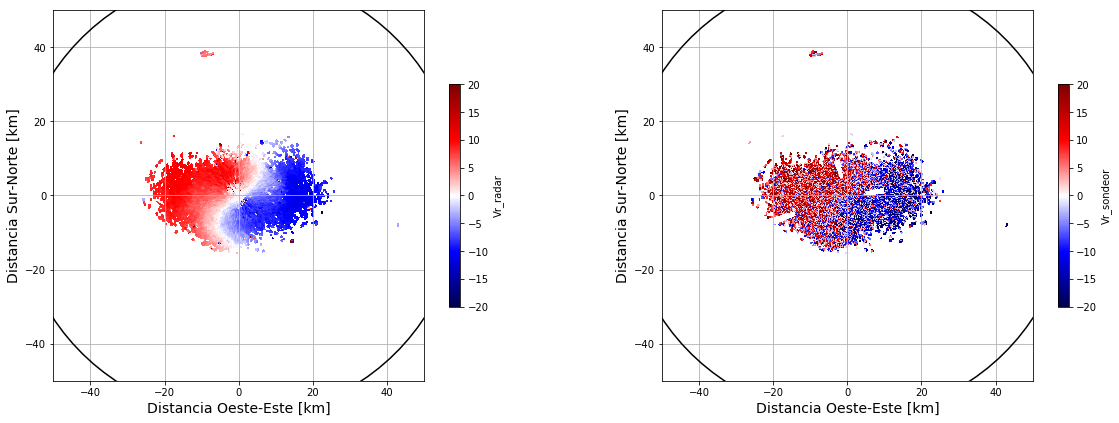

In [45]:
# Grafico para comparar con los datos de radar
#=============================================

# Datos de lat/lon
n = 2
start_index = 361*n
end_index = 361*(n+1)
Vr_ref1 = Vr_ref_m[start_index:end_index , :]
Vr_radar1 = radar.fields['V']['data'][start_index:end_index]
lats = radar.gate_latitude['data'][start_index:end_index]
lons = radar.gate_longitude['data'][start_index:end_index]

# Datos x/y (en metros)
xdist = radar.gate_x['data'][start_index:end_index]/1000.
ydist = radar.gate_y['data'][start_index:end_index]/1000.

fig = plt.figure(figsize=[20,15])


# Graficamos Vr_radar
plt.subplot(221,aspect=1.0)
plt.pcolormesh(xdist, ydist, Vr_radar1, cmap='seismic', vmin=-20, vmax=20)
plt.colorbar(shrink=0.6, label='Vr_radar')

for i in range(60,300,60):
    rr = np.sqrt(i**2)
    thetap = np.linspace(0, 2*np.pi, 100)
    x1 = rr*np.cos(thetap)
    x2 = rr*np.sin(thetap)
    plt.plot(x1, x2, '-k')

plt.xlabel('Distancia Oeste-Este [km]', fontsize=14)
plt.ylabel('Distancia Sur-Norte [km]', fontsize=14)

plt.grid()

plt.xlim([-50,50])
plt.ylim([-50,50])

# Graficamos Vda_ref
plt.subplot(222,aspect=1.0)
plt.pcolormesh(xdist, ydist, Vr_ref1, cmap='seismic', vmin=-20, vmax=20)
plt.colorbar(shrink=0.6, label='Vr_sondeor')

for i in range(60,300,60):
    rr = np.sqrt(i**2)
    thetap = np.linspace(0, 2*np.pi, 100)
    x1 = rr*np.cos(thetap)
    x2 = rr*np.sin(thetap)
    plt.plot(x1, x2, '-k')

plt.xlabel('Distancia Oeste-Este [km]', fontsize=14)
plt.ylabel('Distancia Sur-Norte [km]', fontsize=14)

plt.grid()

plt.xlim([-50,50])
plt.ylim([-50,50])


plt.show()

In [46]:
# Ahora volvemos a viento horizontal!
#====================================

# Parametros

field  = 'Vr_radar'      #Nombre de la variable en el archivo de datos
angmin = 2        #Ángulo de elevación mínimo expresado como indice y empezando en 0
angmax = 7        #Ángulo de elevación máximo expresado como indice
rint   = 0.5      #Radio interior de la arandala a calcular en Km
rext   = 40.0     #Radio exterior de la arandela a calcular
maxgap = 30       #Máximo gap sin datos permitido, en grados
maxNaN = 72      #Cantidad de de datos faltantes en un anillo
lpf    = 'False'  #Usa o no filtro pasa bajo
N      = 12       #Cantidad de datos a usar en el filtro, tiene que ser par!


# Algunas variables que necesito
nelev     = np.arange(angmin, angmax, 1) 
elev_ang  = elev[0]
rings     = np.zeros(shape=(len(elev_ang),2))
rings[:,1] = elev_ang
rango = radar.range['data']
r        = (radar.range['data'])/1000 #En km
DateTime = radar.metadata['start_datetime']
NameRadar= radar.metadata['site_name']

#Inicializo los arrays que van a guardar las variables spd, di, SEspd, SEdi con NaNs
spd   = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
di    = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEspd = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
spd_up = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
spd_dw = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
di_up = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
di_dw = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
var   = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
rmse  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
lev  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
a  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
b  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan

#Calculo la propagación del haz
[r, ht, rh, lea]  = rbp.propagation(r, elev_ang, plot = 'False')

#Fijo el ángulo de elevación
for j in nelev:
    start_index = radar.sweep_start_ray_index['data'][j]
    end_index   = radar.sweep_end_ray_index['data'][j]

    tiempo  = radar.time['data'][start_index:end_index]
    azimuth = radar.azimuth['data'][start_index:end_index]
    Vda_raw = pandas.DataFrame(Vr_ref_m[start_index:end_index, :])
    cos_phi = np.cos((azimuth*np.pi)/180)
    sin_phi = np.sin((azimuth*np.pi)/180)
    lev    = elev_ang[j]
    countrings = 0
    

    for i in range(len(rango)): #Revisa cada gate

        #Subset para hacer VAD en una arandela de radio interior = rint y exterior = rext
        if (rh[i,j] < rint) | (rh[i,j] > rext):
            continue
        
        # Control de calidad de los datos 
        ## Errores aleatorios => Filtro pasa bajo

        if lpf == 'True':

            temp_Vda = np.array(Vda_raw.iloc[:,i]) #Tomo los datos de un anillo o  gate
            Vda = LowPassFilter.lowpassfl(temp_Vda, N) #Pasa por el filtro si corresponde

        else:
            Vda = Vda_raw.iloc[:,i] #Si no pasa por el filtro, solo extraigo la información para el modelo

        #Lo convierto a un DataFrame porque ols usa este tipo de formato
        temp    = pandas.DataFrame({'Vda':Vda, 'cosphi':cos_phi, 'sinphi':sin_phi})

        ## Cantidad de datos por anillo

        if temp.isnull().sum().Vda > maxNaN:
            #print 'muchos NaNs en anillo %s' % (i) 
            continue

        ## Gaps en cada anillo

        countNaN = 0
        for k in range(len(Vda)):
            if Vda_raw.isnull().iloc[k,i]:
                countNaN = countNaN + 1
                if countNaN == maxgap:
                    #print 'gap muy grande en anillo %s' % (i) 
                    continue
            else: countNaN = 0
        #print 'anillo %s válido' % (i)   
        countobs = 360 - temp.isnull().sum().Vda

        # Ahora ajusto los datos a Vr = a0 + a1cos phi + b1 sin phi

        mod     = ols('Vda ~ cos_phi + sin_phi', temp).fit()
        
        countrings = countrings + 1
        #print(mod.summary())

        ## Extraigo los coeficientes y sus errores estandar
        a0      = mod.params.Intercept
        a1      = mod.params.cos_phi
        b1      = mod.params.sin_phi
        Vda_mod = a0 + a1*cos_phi + b1*sin_phi
        a[i,j] = a1
        b[i,j] = b1
        
        ## Varianza según RadxEvad
        var[i,j]= (np.sum(np.power(temp.Vda-Vda_mod,2)))/(countobs-3)
        rmse[i,j]= np.sqrt(var[i,j])
        SEa1    = mod.bse.cos_phi
        SEb1    = mod.bse.sin_phi
        #MSEt     = mod.mse_model
        #RMSEt    = np.sqrt(MSEt)
        #u0      = b1/np.sin((elev*np.pi)/180)
        #v0      = a1/np.cos((elev*np.pi)/180)

        # Calculo el módulo y dirección del viento
        ## spd sale de Browning_and_Wexler pero no logro lograr la igualdad con el modulo, so...
        spd[i,j]    = np.sqrt(np.power(a1,2) + np.power(b1,2))/np.cos((lev*np.pi)/180) 
        #spd     = np.sqrt(np.power(u0,2) + np.power(v0,2))

        if b1 < 0:
            di[i,j] = (np.pi/2 - np.arctan(a1/b1))*180/np.pi #Lo paso a grados
            di_up[i,j] = (np.pi/2 - np.arctan((a1+SEa1)/(b1+SEb1)))*180/np.pi
            di_dw[i,j] = (np.pi/2 - np.arctan((a1-SEa1)/(b1-SEb1)))*180/np.pi
        else:
            di[i,j] = (3*np.pi/2 - np.arctan(a1/b1))*180/np.pi
            di_up[i,j] = (3*np.pi/2 - np.arctan((a1+SEa1)/(b1+SEb1)))*180/np.pi
            di_dw[i,j] = (3*np.pi/2 - np.arctan((a1-SEa1)/(b1-SEb1)))*180/np.pi

        # Calculos el error estandar para cada variable

        #SEspd[i,0]  = (abs(a1)*SEa1 + abs(b1)*SEb1)/np.sqrt(np.power(a1,2) + np.power(b1,2))*np.cos((elev*np.pi)/180) 
        #SEdi[i,0]   = (abs(a1)*SEb1 + abs(b1)*SEa1)/np.sqrt(np.power(a1,2) + np.power(b1,2))
        #Error: calculado como 2*SE de cada parámetro, cual intervalo de confianza
        #spd_up[i,j]  = np.sqrt(np.power((a1+2*SEa1),2) + np.power((b1+2*SEb1),2))/np.cos((elev*np.pi)/180) 
        #spd_dw[i,j]  = np.sqrt(np.power((a1-2*SEa1),2) + np.power((b1-2*SEb1),2))/np.cos((elev*np.pi)/180) 
        #MSE[i,j]    = MSEt
        #RMSE[i,j]   = np.sqrt(MSEt)
    rings[j,0] = countrings
    #print countrings
    
# Guardo todo en un data frame bonito
spd = spd.flatten('F')
rmse = rmse.flatten('F')
di = di.flatten('F')
rh = rh.flatten('F')
ht = ht.flatten('F')
e = np.repeat(elev_ang, len(rango), axis=0)
lev = e.reshape([len(elev_ang), len(rango)]).transpose()
lev = lev.flatten('F')
a = a.flatten('F')
b = b.flatten('F')
vad = pandas.DataFrame({'spd':spd, 'rmse':rmse, 'di':di, 'rh':rh, 'ht':ht, 'lev':lev, 'a':a, 'b':b})

vad.to_csv('evad' + 'Vr_huecos' + DateTime + '-' + NameRadar + '.csv', sep = ';', na_rep = '-9999')
#Muestra por pantalla la cantidad de anillos válidos para cada ángulo de elevación
print rings


/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

[[  0.           0.5       ]
 [  0.           1.29999995]
 [ 33.           2.29999995]
 [ 35.           3.5       ]
 [ 26.           5.        ]
 [ 13.          11.80000019]
 [ 11.          15.10000038]
 [  0.          19.20000076]]


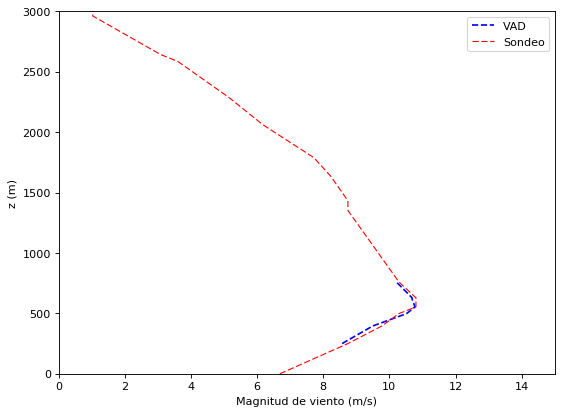

In [109]:
# Gráfico simple para evaluar los resultados cualitativamente

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
#ax.title('Viento calculado con la elevación %s grados'% nelev)
ax.plot(totalvad.spd, totalvad.ht*1000, color='blue',linestyle='--', label='VAD')
ax.plot(V, z, color='red', linewidth=1.0, linestyle='--', label='Sondeo')
ax.legend(loc='upper right')
plt.ylim([0,3000])
plt.xlim([0,15])
ax.set_xlabel('Magnitud de viento (m/s)')
ax.set_ylabel('z (m)')


plt.show()


In [47]:
#Interpolamos a un único perfíl
#==============================

#Ahora queremos interpolar en la grilla del sondeo para poder calcular los errores luego
z = sondeo.soundingdata['hght']-191
# Parámetros
minlev = 0.0  #Nivel inferior en kilometros
maxlev = 3.0  #Nivel superior en kilometros
deltalev = 0.1 #Intervalo de la grilla

pht = []
z_sondeo = z/1000

for m in range(len(z)):
    if z_sondeo[m] > minlev and z_sondeo[m] <= maxlev:
        pht = np.append(pht, z_sondeo[m])

# Generamos la grilla del perfil
pnlevs = len(pht) #Cantidad de niveles

totalvad = pandas.DataFrame(np.zeros(shape=(int(pnlevs),7))*np.nan, columns = ['ht', 'spd', 'rmse', 'rmse2', 'rmse3', 'di', 'rings'])



for l in range(int(pnlevs)):
    
    #pht[l] = minlev + l * deltalev
    upperl = pht[l] + deltalev/2
    lowerl = pht[l] - deltalev/2
    
    #Subset de los datos que se encuentran en la capa
    temp = vad.loc[(vad.ht >= lowerl) & (vad.ht < upperl) & vad.spd  & (vad.spd.notnull())]
    #Cuento la cantidad de anillos válidos en la capa
    ringpl = len(temp.spd)
    temp['u'] = temp.spd * np.sin(temp.di*np.pi/180)
    temp['v'] = temp.spd * np.cos(temp.di*np.pi/180)
    
    #Calculo el promedio de spd para la capa
    w = temp.rmse + temp.rh
    if not w.any():
        continue
        
    spd_wavg = np.average(np.asarray(temp.spd), weights=np.asarray(w))
    u_wavg = np.average(np.asarray(temp.u), weights=np.asarray(temp.rh))
    v_wavg = np.average(np.asarray(temp.v), weights=np.asarray(temp.rh))
    di_wavg = np.arctan2(u_wavg, v_wavg)*180/np.pi
    
    #Calculo el RMSE
    var = sum(np.power(temp.spd-spd_wavg,2)/temp.rmse)/sum(1/temp.rmse)
    rmsec1 = var/np.sqrt(ringpl)
    rmsec2 = np.sqrt(1/(sum(1/np.power(temp.rmse,2))))
    rmsec3 = sum(np.power(temp.spd-spd_wavg,2)/np.sqrt(temp.rmse))/(sum(1/np.sqrt(temp.rmse))*(ringpl-1))
    
    #Guardo en el dataframe
    totalvad.ht[l] = pht[l]
    totalvad.spd[l] = spd_wavg
    totalvad.rmse[l] = rmsec1
    totalvad.rmse2[l] = rmsec2
    totalvad.rmse3[l] = rmsec3
    totalvad.di[l] = di_wavg
    totalvad.rings[l] = ringpl
    
#Escribo un .csv que se guarda con la fecha y la hora del volumen de datos
totalvad.to_csv('Vr_huecos_' + DateTime + '-' + NameRadar + '.csv', sep = ';', na_rep = '-9999')


/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


In [108]:
# Cálculo de errores
#====================

Vr = totalvad.spd
Vr_sondeo = []
z_sondeo = z/1000
for m in range(len(z)):
    if z_sondeo[m] > minlev and z_sondeo[m] <= maxlev:
        Vr_sondeo = np.append(Vr_sondeo, V[m])

resta = Vr - Vr_sondeo
rms = np.sqrt(np.nansum(np.power(resta,2))/len(Vr_sondeo))
rre = np.sqrt(np.nansum(np.power(resta,2))/np.nansum(np.power(Vr_sondeo,2)))
cor = pearsonr(Vr,Vr_sondeo)
print "rms = ", round(rms,3)
print "rre = ", round(rre,3)
print "cor = ", round(cor[0],3)
print Vr, Vr_sondeo

rms =  0.167
rre =  0.016
cor =  0.983
0     8.570466
1     9.498336
2    10.519969
3    10.775361
4    10.685429
5    10.685429
6    10.211176
Name: spd, dtype: float64 [  8.74548   9.77436  10.2888   10.80324  10.80324  10.80324  10.2888 ]
